In [1]:
#IMPORTS

from typing import Annotated, Sequence, List, Literal, TypedDict
from pydantic import BaseModel, Field 
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState

from langgraph.graph.message import add_messages
import asyncio 
from dotenv import load_dotenv
import os 
from agent.request import request_llm
from agent.knowledgebase import data_fetcher
from prompt_library.merger_sys_msg import merger_system_message
load_dotenv()

from langchain_openai import ChatOpenAI
from typing import Optional
from data_ingestion.ingestion_pipeline import get_rag_chain

✅ Connection successful!
✅ Query executed successfully. Rows fetched: 1
embedding model


In [2]:
route_system_message = """You are a customer service routing agent for Tata Capital. Your role is to analyze incoming customer messages and classify them into exactly one of four categories: QUERY, REQUEST, COMPLAINT or KNOWLEDGEBASE.
                                      
Category Definitions
                                      
QUERY
Messages seeking information about Tata Capital, the company, its services, policies, or general inquiries that can be answered using company documentation.
Characteristics:
Questions about company background, history, financial performance
Inquiries about services offered, eligibility criteria, interest rates
General information requests about policies, procedures, or terms
Educational questions about financial products
"What is...", "How does...", "Can you explain...", "Tell me about..."
Examples:
"What is Tata Capital's revenue for this year?"
"How does your personal loan process work?"
"What are the eligibility criteria for home loans?"
"Tell me about Tata Capital's business segments"
"What is the company's market position?"
                                    
REQUEST
Messages asking for specific documents, services, or actions to be performed on behalf of the customer.
Characteristics:
Explicit requests for documents (PAN, Aadhar, CIBIL score, statements, certificates)
Service requests (account opening, loan applications, updates)
Action items that require processing or delivery
"I need...", "Please send...", "Can you provide...", "I want to..."
Examples:
"I need my CIBIL score report"
"Please send me my PAN card copy"
"Can you provide my Aadhar document?"
"I want to request my loan statement"
"Please send the NOC certificate to my email"
"I need my account balance certificate"
                                     
COMPLAINT
Messages providing a ticket number for complaint processing and resolution. The system requires a valid ticket number to scrape complaint details and process sentiment analysis, categorization, and routing.
Characteristics:
Contains a ticket number (various formats: alphanumeric, numeric, with prefixes/suffixes)
References existing complaint or issue tracking
Requests status update or processing of logged complaint
May include phrases like "ticket number", "complaint ID", "reference number"
Customer wants to process or check status of previously logged complaint
Examples:
"Please process my complaint ticket number TC123456"
"My ticket ID is COMP2024001, please update"
"I have complaint reference number 789012, can you check status?"
"Ticket: TC-2024-0456 needs processing"
"My complaint number is 123456789"
"Reference ID: REF789 - please resolve this issue"
                                      
KNOWLEDGEBASE
Messages requesting analytics, insights, reports, or data analysis from the customer support ticket database (QRCKnowledgeBase). These involve querying historical ticket data for business intelligence, performance metrics, trends, and operational insights.
Characteristics:
Requests for analytics, reports, or data insights from ticket database
Questions about ticket volumes, trends, patterns, or statistics
Month-to-Date (MTD), Year-to-Date (YTD), or period-based analysis requests
Sentiment analysis across tickets or time periods
Performance metrics for support teams or processes
Queries about ticket resolution times, escalation patterns, or customer satisfaction
Database analysis for business intelligence purposes
"Show me...", "Analyze...", "What are the trends...", "Generate report...", "MTD analysis..."
Examples:
"Show me MTD ticket volume analysis"
"What are the sentiment trends for this month?"
"Analyze complaint patterns by product category"
"Generate a report of open tickets by escalation level"
"What's the YTD resolution time for technical issues?"
"Show me customer satisfaction trends over the last quarter"
"Analyze ticket distribution by communication mode"
"What are the top 5 complaint categories this month?"
"Generate MTD analysis of negative sentiment tickets"
"Show me escalation patterns for Digital Banking vertical"
"""

In [3]:
#DECLARATIONS

api_key = os.getenv('OPENAI_API_KEY')
open_ai_llm = ChatOpenAI(model = 'gpt-4o-mini', api_key=api_key)

In [4]:
# ALL INTENTS

class IntentSchema(TypedDict):
    intent: Literal["Query", "Request", "Complaint", "knowledgebase"] = Field(
        default= "",
        description="One or more labels that define the nature of the user's input. "
                    "**Query** - for information-seeking questions about tatacapital, "
                    "**Request** - for demands or tasks processing " #actionable
                    "**Complaint** -  for expressions of dissatisfaction or issues, "
                    "and **knowledgebase** - if any question related to database or data retrieveal then use this intent."
    ) 
    message: str = Field(
        default= "",
        description="Extract message corresponding to the intent"
    )
    tone: Optional[Literal["Neutral", "Angry"]] = Field(
        default=None,
        description="REQUIRED for Complaint intent: Must be either 'Neutral' or 'Angry'. "
                    "This field indicates the emotional tone of complaints only. "
                    "Should not be provided for Query, Request, or Other intents."
    )


class IntentSchemas(TypedDict):
    intent_schema_list: List[IntentSchema] = Field(
        default=[],
        description="List of intent-message pairs, including complaints with tone where applicable"
    )
# for outer graph
class MainIntent(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]
    active_intents : list[dict]
    completed_intents : IntentSchemas
    sub_response : list[str]
    active_state : str


class subIntent(TypedDict):
    uid : str
    intent : str
    message : str
    tone : str
    output : str
    active_state : str

In [5]:
# dummy definations

async def query_processor(state : subIntent)-> subIntent:
        print('fetching....RAG')
        qa =await get_rag_chain()
        print('fetched....RAG')
        response =await qa.ainvoke(state['message'])

        return {'output' : response['result']}

async def request_processor(state : subIntent)-> subIntent:
        human_msg = state['message']

        response =request_llm(human_msg)
        # response = request_llm(human_msg)
        # print(f"extracted data : {response}")
        if "message" in response:
            result = response["message"]
            # print(type(result))
        else:
            application_no = response["application_no"]
            process_name = response["process_name"]
            requested_document =    response["requested_document"]
            result = {"Webtop_Id": application_no, 
                    "Process_Name": "NA", 
                    "DocNames": requested_document,
                    "Task_Name": process_name,
                    "Work_Id": 123}
            result = "SR-1320099902 has been raised for the Ops Team in the CRM. The {requested_document} for loan application {application_no} will be sent to the customer's registered email address. Overall Sentiment seems to be 'Neutral"
        return {'output' : result}


async def complaint_processor(state : subIntent)-> subIntent:
        message = state['message']
        tone = state['tone']

        print(f'complaint : {message} , tone : {tone}')
        

        return {'output' : 'ticket against your complaint has been raised your issue will be resolved at priority'}

async def knowledge_fetcher(state : subIntent)-> subIntent:
        print('fetching data.....')
        result =await data_fetcher(state['message'])
        return {'output' : result}
def divertor(state : subIntent)-> subIntent:
    state['active_state'] = 'divertor'
    
    if state['intent'].lower() == 'query':
           
        return Command(
                update = {'active_state' : 'query_processor'},
                goto = 'query_processor'
        )

    elif state['intent'].lower() == 'request':
           
        return Command(
                update = {'active_state' : 'request_processor'},
                goto = 'request_processor'
        )
    
    elif state['intent'].lower() == 'complaint':
           
        return Command(
                update = {'active_state' : 'complaint_processor'},
                goto = 'complaint_processor'
        )
    
    elif state['intent'].lower() == 'knowledgebase':
           
        return Command(
                update = {'active_state' : 'knowledge_fetcher'},
                goto = 'knowledge_fetcher'
        )


In [6]:
#inner graph

SubGraph = StateGraph(subIntent)

SubGraph.add_node('divertor',divertor)
SubGraph.add_node('query_processor',query_processor)
SubGraph.add_node('request_processor',request_processor)
SubGraph.add_node('complaint_processor',complaint_processor)
SubGraph.add_node('knowledge_fetcher',knowledge_fetcher)

SubGraph.add_edge(START,'divertor')

ready_subgraph = SubGraph.compile()

In [7]:
#DEFINATIONS

async def handle_request(message: dict):
    print(f"Starting main node...for : {message.get('intent')}")

    input = {'intent': message.get('intent') ,'message': message.get('message'), 'tone' : message.get('tone')}

    sub_graph_retrieved_state = await ready_subgraph.ainvoke(input)
    return sub_graph_retrieved_state['output']



def intent_classifier(state : MainIntent) -> MainIntent:

    response = open_ai_llm.with_structured_output(IntentSchemas).invoke([route_system_message] + state["messages"])
    print(response.get('intent_schema_list'))
    state['active_intents'].extend(response.get('intent_schema_list'))

    goto = 'intent_invoker'
    return Command(
        update = {'active_state' : goto},
        goto = goto
    )
    

async def intent_invoker(state : MainIntent)-> MainIntent:

    final_states = await asyncio.gather(*(handle_request(msg) for msg in state['active_intents']))

    print(f'final states : {final_states}') 

    goto = 'intent_merger'
    
    return Command(
        update = {
                'sub_response' : final_states,
                'active_state' : goto},
        goto = goto
    )

def intent_merger(state : MainIntent)-> MainIntent:

    output = f"""
        question: {state['messages'][-1].content}
        outputs generated:
        {chr(10).join(f"- {resp}" for resp in state['sub_response'])}
        """

    print(output)
    response = open_ai_llm.invoke([merger_system_message,output])

    state['messages'].append(AIMessage(response.content))

    print(state['messages'][-1])
    

    return state



In [8]:
#outer graph

graph = StateGraph(MainIntent)

graph.add_node('intent_classifier',intent_classifier)
graph.add_node('intent_invoker',intent_invoker)
graph.add_node('intent_merger',intent_merger)

graph.add_edge(START,'intent_classifier')

ready_graph = graph.compile()

In [21]:
input = {'messages' : ['i want to know about count open cases in database and what are the available schemes for tata capital also i am not happy with the portal of tata capital it always lags and sned me loan agreement for appli'], 'active_intents':[]}

graph_retrieved_state = await  ready_graph.ainvoke(input)

[{'intent': 'KNOWLEDGEBASE', 'message': 'I want to know about count open cases in database', 'tone': 'Neutral'}, {'intent': 'QUERY', 'message': 'What are the available schemes for tata capital', 'tone': 'Neutral'}, {'intent': 'COMPLAINT', 'message': 'I am not happy with the portal of tata capital it always lags', 'tone': 'Angry'}, {'intent': 'REQUEST', 'message': 'send me loan agreement for appli', 'tone': 'Neutral'}]
Starting main node...for : KNOWLEDGEBASE
Starting main node...for : QUERY
Starting main node...for : COMPLAINT
Starting main node...for : REQUEST
fetching data.....
fetching....RAG
step 1
fetched....RAG
complaint : I am not happy with the portal of tata capital it always lags , tone : Angry
starting reuest chain
appln no : None, process name : None, doc : None


sql : SELECT COUNT(*) AS OpenCasesCount FROM [CustomerSupportGPT].[dbo].[QRCKnowledgeBase] WHERE [Status] = 'Open', is_count_query : True


✅ Connection successful!
✅ Query executed successfully. Rows fetched: 1
A

In [22]:
graph_retrieved_state

{'messages': [HumanMessage(content='i want to know about count open cases in database and what are the available schemes for tata capital also i am not happy with the portal of tata capital it always lags and sned me loan agreement for appli', additional_kwargs={}, response_metadata={}, id='fc1452f2-259d-4839-97d6-dfea3e3b5367'),
  AIMessage(content="I checked the database and found the following:\n\n**Total Open Cases:** 71  \n\nAt Tata Capital, we offer a variety of loan products to meet your financial needs. Our available schemes include:\n\n1. **Personal Loans**: Unsecured loans for personal expenses, with flexible repayment options.\n2. **Home Loans**: Loans for purchasing or constructing a home, with competitive interest rates.\n3. **Vehicle Loans**: This includes loans for both new and used vehicles, such as used car loans and two-wheeler loans, with flexible repayment options.\n4. **Business Loans**: Financial support for small and medium enterprises to help grow your business.

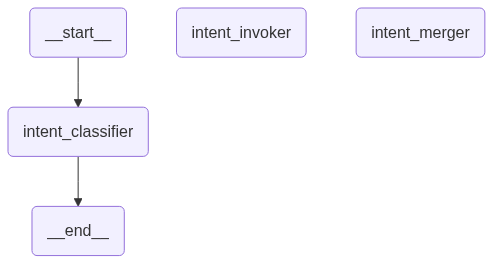

In [ ]:
ready_graph